In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read data

In [2]:
credit = pd.read_excel('../LIVE PROJECT/CreditAnalysis_data.xlsx')
credit.head()

,Unnamed: 0,master_order_id,master_order_status,created,order_id,order_status,ordereditem_quantity,prod_names,ordereditem_unit_price_net,ordereditem_product_id,value,group,dist_names,retailer_names,bill_amount
0,1,25651,delivered,12/18/2017 10:41,25651,delivered,5,ProdName1,43.00,1744.0,215.00,Hyderabad,DistName1,RetailerID2,809.0
1,2,25651,delivered,12/18/2017 10:41,25651,delivered,5,ProdName2,35.54,965.0,177.70,Hyderabad,DistName1,RetailerID2,809.0
2,3,25651,delivered,12/18/2017 10:41,25651,delivered,2,ProdName3,52.80,705.0,105.60,Hyderabad,DistName3,RetailerID29,809.0
3,4,25651,delivered,12/18/2017 10:41,25651,delivered,2,ProdName4,118.28,264.0,236.56,Hyderabad,DistName1,RetailerID87,809.0
4,5,25651,delivered,12/18/2017 10:41,25651,delivered,3,ProdName5,32.22,1025.0,96.66,Hyderabad,DistName4,RetailerID118,809.0


We remove all the unnecessary information decided earlier and save into `clean_credit`.

In [ ]:
clean_credit = credit[(credit['value']!= 0)]

In [5]:
clean_credit = clean_credit[(clean_credit['master_order_status'] != 'cancelled') & (clean_credit['master_order_status'] != 'rejected')]

All missing values have been handled. Unnecessary rows are removed (rejected, cancelled orders).

Since `master_order_id` not unique to each retailers, so we have to create a new column with order id unique to each retailers:

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
clean_credit['dummy_name'] = le.fit_transform(clean_credit.retailer_names.values)
clean_credit['dummy_group'] = le.fit_transform(clean_credit.group.values)
clean_credit['invoice_id'] = clean_credit.dummy_group.astype(str) + clean_credit.dummy_name.astype(str) + clean_credit.master_order_id.astype(str)


In [ ]:
clean_credit.head(10)

# RFM Analysis

### Calculate RFM Metrics

In [8]:
import datetime as dt
from datetime import timedelta

In [7]:
# Let's observe the last transaction date.
# So we can determine the measurement date for calculating how recent retailer's latest purchase was.
clean_credit['created'] = pd.to_datetime(clean_credit['created'])
clean_credit['created'].max()
clean_credit['created'].min()

Timestamp('2017-12-18 10:41:00')

In [ ]:
clean_credit['created'].describe()

In [9]:
# split time datetime into year, month, hour, day of week 
clean_credit['created_year'] = clean_credit['created'].dt.year
clean_credit['created_month'] = clean_credit['created'].dt.month
clean_credit['created_hour'] = clean_credit['created'].dt.hour
clean_credit['created_year_month'] = (
    clean_credit['created'].dt.year.astype('str') + '_' +
    clean_credit['created'].dt.month.astype('str').str.zfill(2)
)
clean_credit['created_dayofweek'] = clean_credit['created'].dt.dayofweek

In [ ]:
clean_credit.head()

- Calculating Recency: 
For each customer ID, we need to calculate the days since the last transaction.
To calculate Days Since Last Transaction, a hypothetical date (Maximum Date + 2) is created to make it seem like we are working on the data 2 days after it was extracted.
Finally, the difference between the Maximum InvoiceDate for each customer and the hypothetical Date created gives us the Date Since the last transaction.

In [10]:
# Assign "performans_date" as 2 days after the last transaction date of purchase:

performans_date = clean_credit["created"].max() + timedelta(days=2)
performans_date

Timestamp('2018-12-05 18:26:00')

Let's create a new dataframe called `customer_data` for calculating Recency, Frequency and Monetary values.
1. Recency : the number of days between performans_date and the last purchase date of each retailer.
2. Frequency: the number of transactions of each retailer.
3. Monetary : the sum of TotalPrice of each retailer.

In [11]:
# Aggregate at customer level
customer_data = pd.DataFrame(clean_credit.pivot_table(index="retailer_names", 
                                              values=["created", "bill_amount",'invoice_id'], 
                                              aggfunc={"created": [min, max], "bill_amount": sum, 'invoice_id':pd.Series.nunique}))

customer_data.head()

bill_amount             created                     invoice_id
                       sum                 max                 min    nunique
retailer_names                                                               
RetailerID1      421557.97 2018-12-03 16:52:00 2018-01-02 06:56:00        189
RetailerID10      68787.08 2018-12-03 06:54:00 2018-01-23 06:30:00         36
RetailerID100    107256.37 2018-12-02 08:01:00 2018-01-03 05:53:00         57
RetailerID101    574727.13 2018-12-03 15:33:00 2017-12-19 07:31:00        265
RetailerID102     35524.84 2018-11-03 13:57:00 2018-01-30 06:51:00         14

In [12]:
# Rename columns
customer_data.columns = ["MonetaryValue", "LastInvoiceDate", "FirstInvoiceDate", "Frequency"]
customer_data.head()

,MonetaryValue,LastInvoiceDate,FirstInvoiceDate,Frequency
retailer_names,,,,
RetailerID1,421557.97,2018-12-03 16:52:00,2018-01-02 06:56:00,189
RetailerID10,68787.08,2018-12-03 06:54:00,2018-01-23 06:30:00,36
RetailerID100,107256.37,2018-12-02 08:01:00,2018-01-03 05:53:00,57
RetailerID101,574727.13,2018-12-03 15:33:00,2017-12-19 07:31:00,265
RetailerID102,35524.84,2018-11-03 13:57:00,2018-01-30 06:51:00,14


 I had concerns about the impact of customer lifetime on frequency and recency values, whether there are bias from lifetime that might cause several RFM score segments to be overestimated.

<AxesSubplot:>

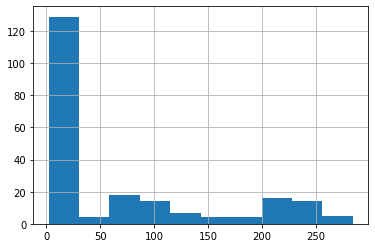

In [13]:
# Calculate recency: the interval (days) between the last transation day and today
customer_data["Recency"] = (performans_date - customer_data["LastInvoiceDate"]) / np.timedelta64(1, 'D')
customer_data["Recency"].hist()

<AxesSubplot:>

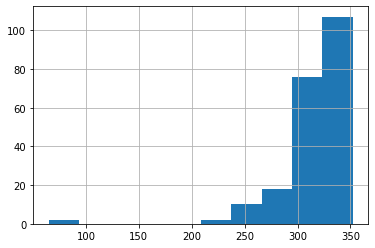

In [14]:
# Calculate customer lifetime: the interval (days) between the first transation day and performans_date
customer_data["Lifetime"] = (performans_date - customer_data["FirstInvoiceDate"]) / np.timedelta64(1, 'D')
customer_data["Lifetime"].hist()

In [ ]:
plt.boxplot(customer_data.Lifetime) 

In [ ]:
customer_data["Frequency"].hist()

In [ ]:
customer_data["MonetaryValue"].describe() 

<AxesSubplot:>

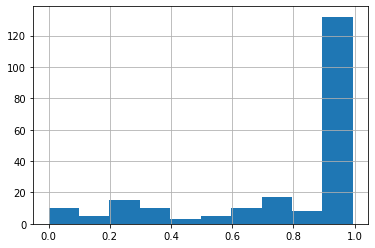

In [15]:
# Calculate the relative recency: recency / customer lifetime
# Note: this is to normalise the fact that newer customers have lower lifetime and thus lower recency
# by nature.
customer_data["RelRecency"] = 1 - customer_data["Recency"] / customer_data["Lifetime"]
customer_data["RelRecency"].hist()

In [ ]:
customer_data["Recency"].describe()

In [ ]:
customer_data["RelRecency"].describe()

In [ ]:
customer_data["RelRecency"].hist()

In [ ]:
sum(customer_data["RelRecency"]==0) / len(customer_data)
# This shows that 2.8% customers --> around 6 retailers only had one transactions.

In [16]:
# Calculate the relative frequency: frequency / customer lifetime
# Note: this is to normalise the fact that newer customers have lower lifetime and thus lower frequency by nature.
customer_data["RelFrequency"] = customer_data["Frequency"] / customer_data["Lifetime"]
customer_data["RelFrequency"].apply(lambda x: np.isinf(x)).value_counts()
# No record with inifinity value  --> No zero recency/zero lifetime

False    215
Name: RelFrequency, dtype: int64

<AxesSubplot:>

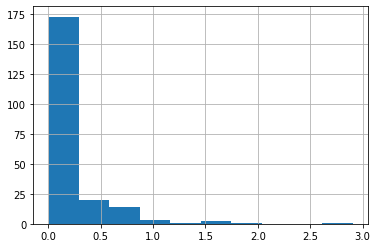

In [17]:
customer_data = customer_data[customer_data["RelFrequency"].apply(lambda x: np.isinf(x))==False]
customer_data["RelFrequency"].hist()
# There are some outliers in terms of frequency

In [ ]:
customer_data["RelFrequency"].describe()

In [ ]:
customer_data["MonetaryValue"].describe()

In [ ]:
customer_data["MonetaryValue"].hist()
# There are some outliers in terms of monetary value.

<AxesSubplot:>

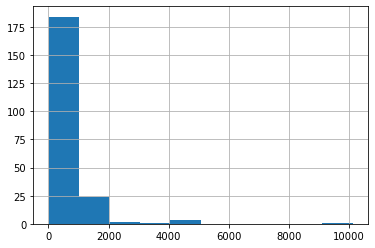

In [18]:
customer_data["RelMonetaryValue"] = customer_data["MonetaryValue"] / customer_data["Lifetime"]
customer_data["RelMonetaryValue"].hist()

In [ ]:
customer_data["RelMonetaryValue"].describe()

### Create RFM buckets using absolute values

In [ ]:
# Create RFM buckets using absolute values
# For this analysis, we take the medians and 75% quartiles of relative recency, relative frequency and relative monetary value and use them for
# 4 bins for each variable. We label those bins as 1, 2, 3 and 4 and use them as the scores for R, F and M respectively.
# By doing so we end up with 10 clusters ()

In [19]:
customer_data['RecencyScore'] = pd.cut(customer_data["Recency"], 
                                       bins=[-1, 
                                             np.percentile(customer_data["Recency"], 25), 
                                             np.percentile(customer_data["Recency"], 50), 
                                             np.percentile(customer_data["Recency"], 75), 
                                             customer_data["Recency"].max()], 
                                       labels=[4, 3, 2, 1]).astype("int")
customer_data["RecencyScore"].value_counts()

4    56
1    54
2    53
3    52
Name: RecencyScore, dtype: int64

In [20]:
customer_data["FrequencyScore"] = pd.cut(customer_data["Frequency"], 
                                       bins=[-1, 
                                             np.percentile(customer_data["Frequency"], 25), 
                                             np.percentile(customer_data["Frequency"], 50), 
                                             np.percentile(customer_data["Frequency"], 75), 
                                             customer_data["Frequency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["FrequencyScore"].value_counts()

1    55
4    54
2    54
3    52
Name: FrequencyScore, dtype: int64

In [21]:
customer_data["MonetaryScore"] = pd.cut(customer_data["MonetaryValue"], 
                                       bins=[customer_data["MonetaryValue"].min()-1, 
                                             np.percentile(customer_data["MonetaryValue"], 25),
                                             np.percentile(customer_data["MonetaryValue"], 50), 
                                             np.percentile(customer_data["MonetaryValue"], 75), 
                                             customer_data["MonetaryValue"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["MonetaryScore"].value_counts()

4    54
2    54
1    54
3    53
Name: MonetaryScore, dtype: int64

In [22]:
customer_data["RFM"] = customer_data["RecencyScore"] + customer_data["FrequencyScore"] + customer_data["MonetaryScore"]
customer_data["RFM"].value_counts()

12    37
3     30
6     23
9     20
5     20
8     19
4     19
10    17
7     17
11    13
Name: RFM, dtype: int64

In [23]:
rfm_abs = pd.DataFrame(customer_data.pivot_table(index=["RFM"], 
                                    values=["Recency", "Frequency", "MonetaryValue", "Lifetime"], 
                                    aggfunc={"Recency": [np.min, np.median, np.max], 
                                             "Frequency": [np.min, np.median, np.max], 
                                             "MonetaryValue": [np.min, np.median, np.max], 
                                             "Lifetime": [np.min, np.median, np.max, "count"]}))
rfm_abs
# We observe median because RFM values are skewed.

Frequency                Lifetime                                \
         amax amin median        amax        amin count      median   
RFM                                                                   
3           9    1    5.0  315.531250  216.513889    30  285.962500   
4          11    1    6.0  337.477083   64.538194    19  305.273611   
5          24    2   12.5  337.355556  216.000000    20  309.884722   
6          35    6   19.0  352.322917  289.467361    23  310.513889   
7          64   10   18.0  351.436806  295.533333    17  309.376389   
8          59   17   35.0  351.454861  295.575694    19  336.459028   
9          74   21   47.5  351.484722  304.622917    20  336.523958   
10        165   30   53.0  352.322917  314.400000    17  336.483333   
11        157   87  111.0  351.454861  336.522917    13  351.400694   
12       1022   85  226.0  352.322917  336.450694    37  348.587500   

    MonetaryValue                            Recency                         
             amax       amin      median        amax       amin      median  
RFM                                                                          
3        17664.91     425.42    5769.415  284.584722  94.464583  231.270486  
4        35759.46     281.00   10158.290  252.075694   3.434028   64.538194  
5        50796.17    4801.71   26693.640  250.075694   2.520833  125.017361  
6        62700.18   10668.44   32508.890  251.040278   2.393056   64.447222  
7       139577.10   18077.71   35567.330  124.591667   2.485417    2.529167  
8       123344.78   29832.55   82634.370   93.102778   2.190972    3.495833  
9       170724.47   54525.09   86594.250   63.523611   2.120139    2.521528  
10      458681.75   58500.43   97087.960   63.455556   2.000000    2.461111  
11      364510.71  117631.62  211942.770    3.423611   2.120139    2.510417  
12     3562912.89  146959.20  506338.440    2.480556   2.000000    2.093056

Lifetime median is quite constant across all clusters. There are no bias from lifetime. 

### Create RFM buckets using relative values

In [24]:
# Create RFM buckets using relative values
customer_data["RecencyScore"] = pd.cut(customer_data["RelRecency"], 
                                       bins=[-1, 
                                             np.percentile(customer_data["RelRecency"], 25), 
                                             np.percentile(customer_data["RelRecency"], 50), 
                                             np.percentile(customer_data["RelRecency"], 75), 
                                             customer_data["RelRecency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["RecencyScore"].value_counts()

4    54
2    54
1    54
3    53
Name: RecencyScore, dtype: int64

In [25]:
customer_data["FrequencyScore"] = pd.cut(customer_data["RelFrequency"], 
                                       bins=[-1, 
                                             np.percentile(customer_data["RelFrequency"], 25), 
                                             np.percentile(customer_data["RelFrequency"], 50), 
                                             np.percentile(customer_data["RelFrequency"], 75), 
                                             customer_data["RelFrequency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["FrequencyScore"].value_counts()

1    55
4    54
3    53
2    53
Name: FrequencyScore, dtype: int64

In [26]:
customer_data["MonetaryScore"] = pd.cut(customer_data["RelMonetaryValue"], 
                                       bins=[customer_data["RelMonetaryValue"].min()-1, 
                                             np.percentile(customer_data["RelMonetaryValue"], 25),
                                             np.percentile(customer_data["RelMonetaryValue"], 50), 
                                             np.percentile(customer_data["RelMonetaryValue"], 75), 
                                             customer_data["RelMonetaryValue"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["MonetaryScore"].value_counts()

4    54
2    54
1    54
3    53
Name: MonetaryScore, dtype: int64

In [27]:
customer_data["RFM"] = customer_data["RecencyScore"] + customer_data["FrequencyScore"] + customer_data["MonetaryScore"]
customer_data["RFM"].value_counts()

12    38
3     30
4     22
9     21
6     20
8     19
7     19
5     18
10    16
11    12
Name: RFM, dtype: int64

In [28]:
# using relative values
rfm_rel = pd.DataFrame(customer_data.pivot_table(index=["RFM"], 
                                    values=["Recency", "Frequency", "MonetaryValue", "Lifetime"], 
                                    aggfunc={"Recency": [np.min, np.median, np.max], 
                                             "Frequency": [np.min, np.median, np.max], 
                                             "MonetaryValue": [np.min, np.median, np.max], 
                                             "Lifetime": [np.min, np.median, np.max, "count"]}))
rfm_rel
# Note that the median lifetime is rather constant across clusters.
# our segmentation is not biased by the lifetime of the customers.

Frequency                Lifetime                                \
         amax amin median        amax        amin count      median   
RFM                                                                   
3           9    1    4.0  315.531250   64.538194    30  284.468403   
4          12    2    7.0  337.477083  216.000000    22  306.832292   
5          24    4   12.5  337.355556  263.547917    18  308.935764   
6          30   10   18.5  352.322917  289.467361    20  313.417361   
7          64   10   18.0  351.454861  295.533333    19  310.377083   
8          59   17   35.0  337.473611  295.575694    19  335.083333   
9          77   21   47.0  352.322917  304.622917    21  336.459028   
10        165   34   57.0  352.322917  314.400000    16  337.434375   
11        262   74  102.5  351.454861  336.470833    12  337.529167   
12       1022   85  220.5  352.322917  336.450694    38  350.456597   

    MonetaryValue                            Recency                         
             amax       amin      median        amax       amin      median  
RFM                                                                          
3        14272.10     281.00    4788.215  284.584722  64.538194  231.270486  
4        35759.46    1206.30   12726.505  252.075694   2.552083   93.484375  
5        50796.17    5614.12   26693.640  250.075694   2.393056  125.017361  
6        55148.01   12559.42   33738.075  251.040278   2.526389   64.471528  
7       139577.10   18077.71   36496.140  215.613889   2.485417    2.543750  
8       123344.78   29832.55   82634.370   93.102778   2.190972    3.506944  
9       165260.21   54525.09   70594.020   63.523611   2.120139    2.516667  
10      458681.75   58114.42  134216.130   63.455556   2.190972    2.509722  
11      582629.53  117631.62  190888.165    2.552083   2.000000    2.494792  
12     3562912.89  179337.49  481420.875    2.510417   2.000000    2.093056

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Median Lifetime of RFM Segments (Absolute vs Relative)')
rfm_abs["Lifetime"]["median"].plot(ax=axes[0], kind="bar")
rfm_rel["Lifetime"]["median"].plot(ax=axes[1], kind="bar")
plt.show()
# There are no difference between absolute and relative lifetime

## Is there correlation between RFM Values?

In [ ]:
sns.regplot(x=customer_data['Frequency'],y=customer_data['MonetaryValue'])

In [ ]:
sns.relplot(x="Frequency", y="MonetaryValue", data=customer_data, kind = 'scatter')

In [ ]:
sns.pairplot(customer_data.iloc[:,[0,3,4]])                            
# Correlation matrix 


In [ ]:
np.corrcoef(customer_data.Frequency, customer_data.Recency) 

In [ ]:
customer = customer_data.iloc[:,[0,3,4]]
customer.head(3)

In [ ]:
correlation_matrix = customer.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

### Segregate retailers into segments

In [29]:
# From these statistics we can generate some heuristic business rules to simplify our segmentation.
customer_data["last_order_within_4d"] = customer_data["Recency"]<4 # Had transactions in the last 4 days
customer_data["more_than_26_orders"] = customer_data["Frequency"]>26 # made more than 26 orders
customer_data["value_higher_than_400k"] = customer_data["MonetaryValue"]>400000 # Sum of value higher than 400K
customer_data.groupby(["last_order_within_4d", "more_than_26_orders", "value_higher_than_400k"]).count()["Lifetime"]

last_order_within_4d  more_than_26_orders  value_higher_than_400k
False                 False                False                     72
                      True                 False                     13
                                           True                       1
True                  False                False                     34
                      True                 False                     68
                                           True                      27
Name: Lifetime, dtype: int64

In [67]:
conditions = [
    (customer_data["last_order_within_4d"]==True)&(customer_data["more_than_26_orders"]==True)
    &(customer_data["value_higher_than_400k"]==True),
    
    (customer_data["last_order_within_4d"]==True)&(customer_data["more_than_26_orders"]==True)
    &(customer_data["value_higher_than_400k"]==False),
    
    (customer_data["last_order_within_4d"]==False)&(customer_data["more_than_26_orders"]==True),
    (customer_data["last_order_within_4d"]==True)&(customer_data["more_than_26_orders"]==False),
    (customer_data["last_order_within_4d"]==False)&(customer_data["more_than_26_orders"]==False)
]
mappings = ["01. High Engagement & High Value", 
            "02. High Engagement & Low Value", 
           "03. High Frequency but Recently Inactive", 
              "04. Low Frequency but Recently Active", 
            "05. Low Engagement & Low Value"]
customer_data['FinalRFM'] = np.select(conditions, mappings, default="Others")
customer_data['FinalRFM'].value_counts()



05. Low Engagement & Low Value              72
02. High Engagement & Low Value             68
04. Low Frequency but Recently Active       34
01. High Engagement & High Value            27
03. High Frequency but Recently Inactive    14
Name: FinalRFM, dtype: int64

In [68]:
customer_data.pivot_table(index=["FinalRFM"], 
                          values=["Recency", "Frequency", "MonetaryValue", "Lifetime"], 
                          aggfunc={"Recency": [np.min, np.median, np.max], 
                                   "Frequency": [np.min, np.median, np.max], 
                                   "MonetaryValue": [np.min, np.median, np.max], 
                                   "Lifetime": [np.min, np.median, np.max, "count"]})

Frequency                Lifetime  \
                                              amax amin median        amax   
FinalRFM                                                                     
01. High Engagement & High Value              1022  180  261.0  351.484722   
02. High Engagement & Low Value                198   29   54.0  352.322917   
03. High Frequency but Recently Inactive       165   27   35.5  351.436806   
04. Low Frequency but Recently Active           26    2   16.5  337.513194   
05. Low Engagement & Low Value                  25    1    7.5  352.322917   

                                                                        \
                                                amin count      median   
FinalRFM                                                                 
01. High Engagement & High Value          336.450694    27  348.587500   
02. High Engagement & Low Value           295.575694    68  337.378472   
03. High Frequency but Recently Inactive  309.439583    14  326.235764   
04. Low Frequency but Recently Active     216.000000    34  309.948958   
05. Low Engagement & Low Value             64.538194    72  304.823611   

                                         MonetaryValue                         \
                                                  amax       amin      median   
FinalRFM                                                                        
01. High Engagement & High Value            3562912.89  402308.79  574727.130   
02. High Engagement & Low Value              364510.71   37326.46  106643.145   
03. High Frequency but Recently Inactive     458681.75   36496.14   82842.475   
04. Low Frequency but Recently Active         74577.47    4801.71   23371.020   
05. Low Engagement & Low Value                55148.01     281.00   11469.985   

                                             Recency                         
                                                amax       amin      median  
FinalRFM                                                                     
01. High Engagement & High Value            2.475694   2.000000    2.068750  
02. High Engagement & Low Value             3.661806   2.000000    2.510417  
03. High Frequency but Recently Inactive  215.613889  32.436111   64.030903  
04. Low Frequency but Recently Active       3.570139   2.120139    2.531944  
05. Low Engagement & Low Value            284.584722  32.172222  186.502778

- **High Engagement & High Value (27)** are those who had their last transactions in the last 4 days, made more than 26 transactions, and contributed more than 400K on average.
- **High Engagement & Low Value (68)** are those who are as active as Group1 and contributed less than 400K.
- **Low Frequency but Recently Active (34)** are those who had their last transactions in the last 4 days but made no more than 26 transactions. These customers also have a lower monetary value..
- **High Frequency but Recently Inactive (14)** are those who did not have any transactions in the last 4 days. However, on average they had more than 26 transactions. These customers were very active at the beginning of their journey but are not that active recently. We need to find ways to reengage them.
- **Low Engagement & Low Value (72)** are those who did not have any transactions in the last 4 days, made no more than 26 transactions, and contributed the lowest revenue. Apparently, several customers in this group are recently acquired customers (their average lifetime is less than 100 days) but only made 1 transaction.
 

In [69]:
# merge customer_data with clean_credit
all_data = clean_credit.merge(right=customer_data, how="inner", left_on="retailer_names", right_on="retailer_names")
all_data.head(3)

,Unnamed: 0,master_order_id,master_order_status,created,ordereditem_quantity,prod_names,ordereditem_unit_price_net,value,group,retailer_names,...,RelMonetaryValue,RecencyScore,FrequencyScore,MonetaryScore,RFM,last_order_within_4d,more_than_26_orders,value_higher_than_400k,CreditScore,FinalRFM
0,1,25651,delivered,2017-12-18 10:41:00,5,ProdName1,43.00,215.00,Hyderabad,RetailerID2,...,361.820517,3,3,3,9,True,True,False,02. Good,02. High Engagement & Low Value
1,2,25651,delivered,2017-12-18 10:41:00,5,ProdName2,35.54,177.70,Hyderabad,RetailerID2,...,361.820517,3,3,3,9,True,True,False,02. Good,02. High Engagement & Low Value
2,143,25684,processed,2018-01-23 06:30:00,2,ProdName118,48.29,96.58,Hyderabad,RetailerID2,...,361.820517,3,3,3,9,True,True,False,02. Good,02. High Engagement & Low Value


### Observe Cluster

In [82]:
grouped_cust = all_data[['retailer_names', 'MonetaryValue', 'Frequency', 'Recency',
       'FinalRFM']].groupby('FinalRFM').median()
grouped_cust.sort_values(['MonetaryValue'], ascending=False,inplace=True)


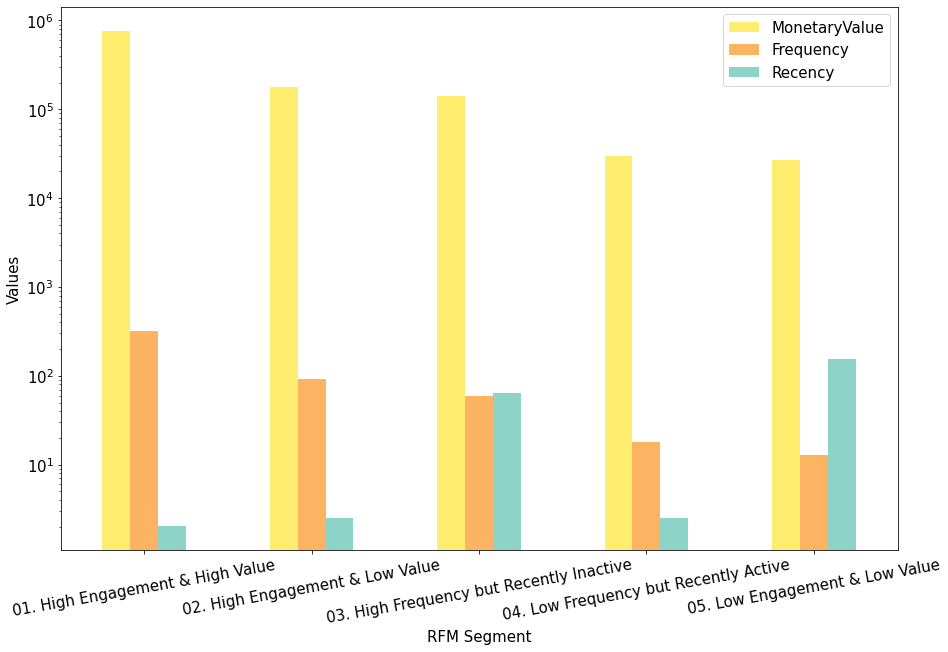

In [88]:
#plt.figure(figsize=(25,20))
grouped_cust = all_data[['retailer_names', 'MonetaryValue', 'Frequency', 'Recency',
       'FinalRFM']].groupby('FinalRFM').median()
grouped_cust.sort_values(['MonetaryValue'], ascending=False,inplace=True)
myfig = grouped_cust.plot(kind='bar',logy=True, colormap='Set3_r', fontsize=15, figsize=(15,10)) 
plt.xticks(rotation=10)
plt.xlabel('RFM Segment', fontsize=15)
plt.ylabel('Values', fontsize=15)
plt.legend(fontsize=15) # using a size in points
#plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12) 
plt.show()

